In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Data loading and transformation
transform = transforms.Compose([transforms.ToTensor()])

train_loader = datasets.MNIST('./data',
                              train= True,
                             download=True,
                             transform = transform)
indices = torch.arange(100)
train_loader = Subset(train_loader, indices)
train_loader = DataLoader(train_loader, batch_size=64,shuffle=True, num_workers=0)


test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)



In [ ]:
# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128 * 4 * 4, 12)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(12,32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, Encoder):
        super(CombinedModel, self).__init__()
        self.encoder = Encoder
        self.classifier = Classifier()

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [ ]:
ourEncoder = Encoder()


In [ ]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CombinedModel(ourEncoder).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 30
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


100%|██████████| 1250/1250 [00:04<00:00, 293.29it/s]


Epoch [1/32], Train Loss: 2.2824, Train Acc: 5.00%, Test Loss: 2.2386, Test Acc: 11.21%


100%|██████████| 1250/1250 [00:04<00:00, 300.57it/s]


Epoch [2/32], Train Loss: 2.1748, Train Acc: 16.00%, Test Loss: 2.1793, Test Acc: 19.09%


100%|██████████| 1250/1250 [00:05<00:00, 241.85it/s]


Epoch [3/32], Train Loss: 2.0491, Train Acc: 27.00%, Test Loss: 2.0828, Test Acc: 24.35%


100%|██████████| 1250/1250 [00:04<00:00, 299.76it/s]


Epoch [4/32], Train Loss: 1.8943, Train Acc: 35.00%, Test Loss: 1.9631, Test Acc: 32.62%


100%|██████████| 1250/1250 [00:04<00:00, 294.51it/s]


Epoch [5/32], Train Loss: 1.6697, Train Acc: 46.00%, Test Loss: 1.8691, Test Acc: 44.60%


100%|██████████| 1250/1250 [00:04<00:00, 272.44it/s]


Epoch [6/32], Train Loss: 1.4970, Train Acc: 60.00%, Test Loss: 1.7530, Test Acc: 44.38%


100%|██████████| 1250/1250 [00:04<00:00, 276.48it/s]


Epoch [7/32], Train Loss: 1.2883, Train Acc: 65.00%, Test Loss: 1.6425, Test Acc: 47.71%


100%|██████████| 1250/1250 [00:04<00:00, 260.14it/s]


Epoch [8/32], Train Loss: 1.1419, Train Acc: 66.00%, Test Loss: 1.5770, Test Acc: 51.81%


100%|██████████| 1250/1250 [00:04<00:00, 294.00it/s]


Epoch [9/32], Train Loss: 0.8984, Train Acc: 76.00%, Test Loss: 1.6217, Test Acc: 54.65%


100%|██████████| 1250/1250 [00:03<00:00, 321.56it/s]


Epoch [10/32], Train Loss: 0.7710, Train Acc: 77.00%, Test Loss: 1.4932, Test Acc: 56.45%


100%|██████████| 1250/1250 [00:05<00:00, 239.53it/s]


Epoch [11/32], Train Loss: 0.6735, Train Acc: 80.00%, Test Loss: 1.4764, Test Acc: 56.96%


100%|██████████| 1250/1250 [00:04<00:00, 276.71it/s]


Epoch [12/32], Train Loss: 0.5491, Train Acc: 82.00%, Test Loss: 1.7675, Test Acc: 54.18%


100%|██████████| 1250/1250 [00:04<00:00, 268.28it/s]


Epoch [13/32], Train Loss: 0.4824, Train Acc: 86.00%, Test Loss: 1.6313, Test Acc: 56.54%


100%|██████████| 1250/1250 [00:05<00:00, 216.97it/s]


Epoch [14/32], Train Loss: 0.3551, Train Acc: 89.00%, Test Loss: 1.4957, Test Acc: 60.84%


100%|██████████| 1250/1250 [00:04<00:00, 253.11it/s]


Epoch [15/32], Train Loss: 0.3377, Train Acc: 91.00%, Test Loss: 1.4648, Test Acc: 62.93%


100%|██████████| 1250/1250 [00:05<00:00, 215.87it/s]


Epoch [16/32], Train Loss: 0.2428, Train Acc: 94.00%, Test Loss: 1.5673, Test Acc: 61.78%


100%|██████████| 1250/1250 [00:04<00:00, 256.28it/s]


Epoch [17/32], Train Loss: 0.1938, Train Acc: 98.00%, Test Loss: 1.6221, Test Acc: 60.60%


100%|██████████| 1250/1250 [00:05<00:00, 243.76it/s]


Epoch [18/32], Train Loss: 0.1772, Train Acc: 95.00%, Test Loss: 1.6756, Test Acc: 61.99%


100%|██████████| 1250/1250 [00:05<00:00, 230.86it/s]


Epoch [19/32], Train Loss: 0.1099, Train Acc: 99.00%, Test Loss: 1.7972, Test Acc: 64.22%


100%|██████████| 1250/1250 [00:04<00:00, 263.78it/s]


Epoch [20/32], Train Loss: 0.0955, Train Acc: 99.00%, Test Loss: 1.7914, Test Acc: 65.89%


100%|██████████| 1250/1250 [00:05<00:00, 219.31it/s]


Epoch [21/32], Train Loss: 0.0656, Train Acc: 99.00%, Test Loss: 1.7641, Test Acc: 66.07%


100%|██████████| 1250/1250 [00:04<00:00, 255.47it/s]


Epoch [22/32], Train Loss: 0.0449, Train Acc: 99.00%, Test Loss: 1.8072, Test Acc: 65.22%


100%|██████████| 1250/1250 [00:05<00:00, 214.61it/s]


Epoch [23/32], Train Loss: 0.0368, Train Acc: 100.00%, Test Loss: 1.8793, Test Acc: 64.53%


100%|██████████| 1250/1250 [00:04<00:00, 250.37it/s]


Epoch [24/32], Train Loss: 0.0271, Train Acc: 100.00%, Test Loss: 1.9398, Test Acc: 64.54%


100%|██████████| 1250/1250 [00:05<00:00, 248.96it/s]


Epoch [25/32], Train Loss: 0.0210, Train Acc: 100.00%, Test Loss: 1.9439, Test Acc: 65.39%


100%|██████████| 1250/1250 [00:05<00:00, 211.49it/s]


Epoch [26/32], Train Loss: 0.0141, Train Acc: 100.00%, Test Loss: 1.9199, Test Acc: 66.71%


100%|██████████| 1250/1250 [00:04<00:00, 260.46it/s]


Epoch [27/32], Train Loss: 0.0114, Train Acc: 100.00%, Test Loss: 1.9051, Test Acc: 67.40%


100%|██████████| 1250/1250 [00:05<00:00, 222.12it/s]


Epoch [28/32], Train Loss: 0.0105, Train Acc: 100.00%, Test Loss: 1.9175, Test Acc: 67.74%


100%|██████████| 1250/1250 [00:04<00:00, 265.22it/s]


Epoch [29/32], Train Loss: 0.0087, Train Acc: 100.00%, Test Loss: 1.9687, Test Acc: 67.64%


100%|██████████| 1250/1250 [00:05<00:00, 248.05it/s]


Epoch [30/32], Train Loss: 0.0070, Train Acc: 100.00%, Test Loss: 2.0327, Test Acc: 67.47%


100%|██████████| 1250/1250 [00:05<00:00, 231.67it/s]


Epoch [31/32], Train Loss: 0.0054, Train Acc: 100.00%, Test Loss: 2.0944, Test Acc: 67.11%


100%|██████████| 1250/1250 [00:04<00:00, 260.61it/s]

Epoch [32/32], Train Loss: 0.0047, Train Acc: 100.00%, Test Loss: 2.1385, Test Acc: 66.88%


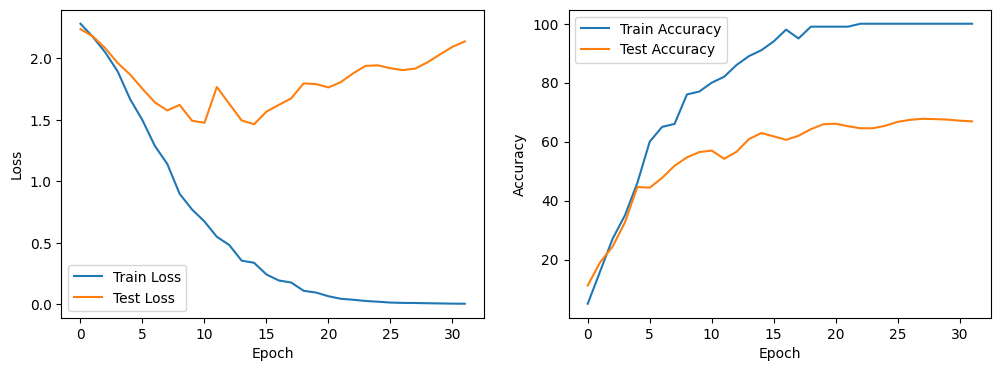

In [ ]:
# Plotting training and test errors and accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()